### Optimal control of the Wilson-Cowan model
This notebook shows how to compute the optimal control (OC) signal for the Wilson-Cowan model for a simple example task.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We stimulate the system with a known control signal, define the resulting activity as target, and compute the optimal control for this target. We define weights such that precision is penalized only (w_p=1, w_2=0). Hence, the optimal control signal should converge to the input signal.

In [12]:
# We import the model
model = WCModel()

# Some parameters to define stimulation signals
dt = model.params["dt"]
duration = 10.
amplitude = 1.
period = duration /4.

# We define a "zero-input", and a sine-input
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-1] = amplitude * np.sin(2.*np.pi*np.arange(0,duration-0.1, dt)/period) # other functions or random values can be used as well

# We set the duration of the simulation and the initial values
model.params["duration"] = duration
x_init = 0.011225367461896877
y_init = 0.013126741089502588
model.params["exc_init"] = np.array([[x_init]])
model.params["inh_init"] = np.array([[y_init]])

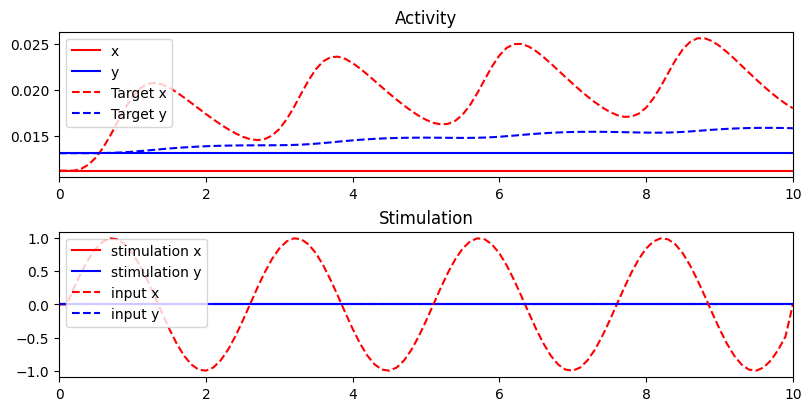

In [13]:
# We set the stimulus in x and y variables, and run the simulation
model.params["exc_ext"] = input
model.params["inh_ext"] = zero_input
model.run()

# Define the result of the stimulation as target
target = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)
target_input = np.concatenate( (input,zero_input), axis=0)[np.newaxis,:,:]

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input
model.params["inh_ext"] = zero_input
control = np.concatenate( (zero_input,zero_input), axis=0)[np.newaxis,:,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate((np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis],
    np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_singlenode(duration, dt, state, target, control, target_input)

Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 0.00041810554198290294
Cost in iteration 25: 1.0391754223401686e-05
Cost in iteration 50: 3.49573311994807e-06
Cost in iteration 75: 2.050435864552942e-06
Cost in iteration 100: 1.4769550220757314e-06
Cost in iteration 125: 1.0978455049231937e-06
Cost in iteration 150: 8.46317377165935e-07
Cost in iteration 175: 6.709426069241103e-07
Cost in iteration 200: 5.514880796974388e-07
Cost in iteration 225: 4.588566024278725e-07
Cost in iteration 250: 3.887290908518017e-07
Cost in iteration 275: 3.3460855277060246e-07
Cost in iteration 300: 2.8916792876573884e-07
Cost in iteration 325: 2.5170145889125204e-07
Cost in iteration 350: 2.235278708441585e-07
Cost in iteration 375: 1.9933716013520986e-07
Cost in iteration 400: 1.7815855717031107e-07
Cost in iteration 425: 1.5960663251724382e-07
Cost in iteration 450: 1.452390728312182e-07
Cost in iteration 475: 1.3183495313931212e-07
Cost in itera

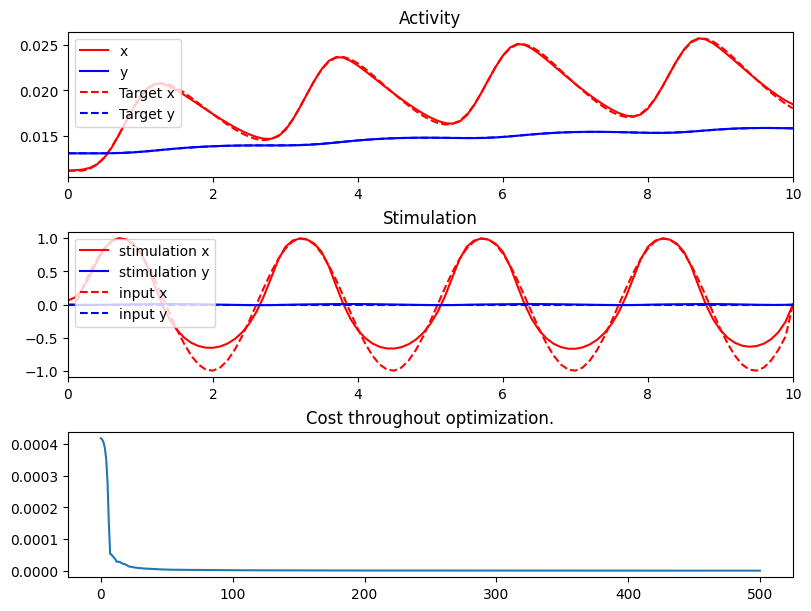

In [14]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,501,25))
model_controlled.weights["w_p"] = 1. # default value 1
model_controlled.weights["w_2"] = 0. # default value 0

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

Compute control for a deterministic system
Cost in iteration 0: 1.209768933033957e-07
Cost in iteration 25: 1.106909320832288e-07
Cost in iteration 50: 1.0152546144362092e-07
Cost in iteration 75: 9.392728045778618e-08
Cost in iteration 100: 8.696549730043331e-08
Final cost : 8.696549730043331e-08


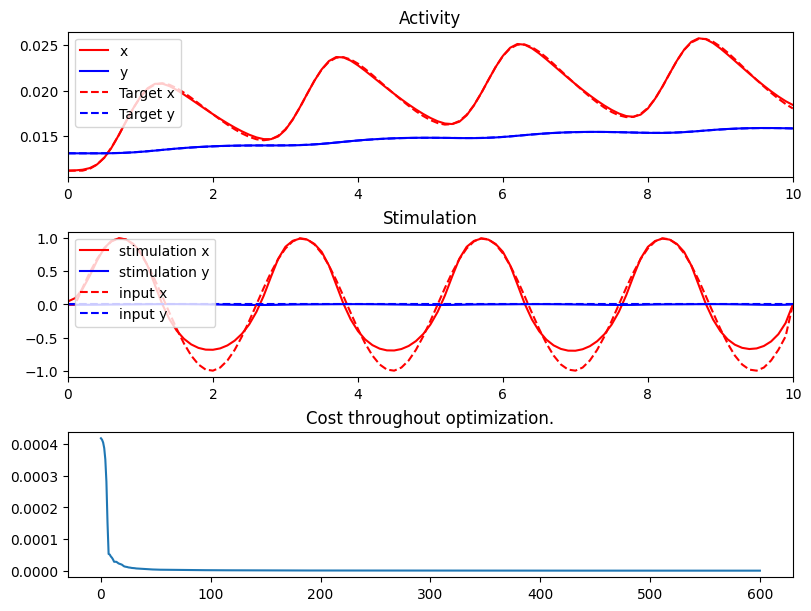

In [15]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

### Network case

Let us know study a simple 2-node network of model oscillators. We first define the coupling matrix and the distance matrix. We can then initialize the model.

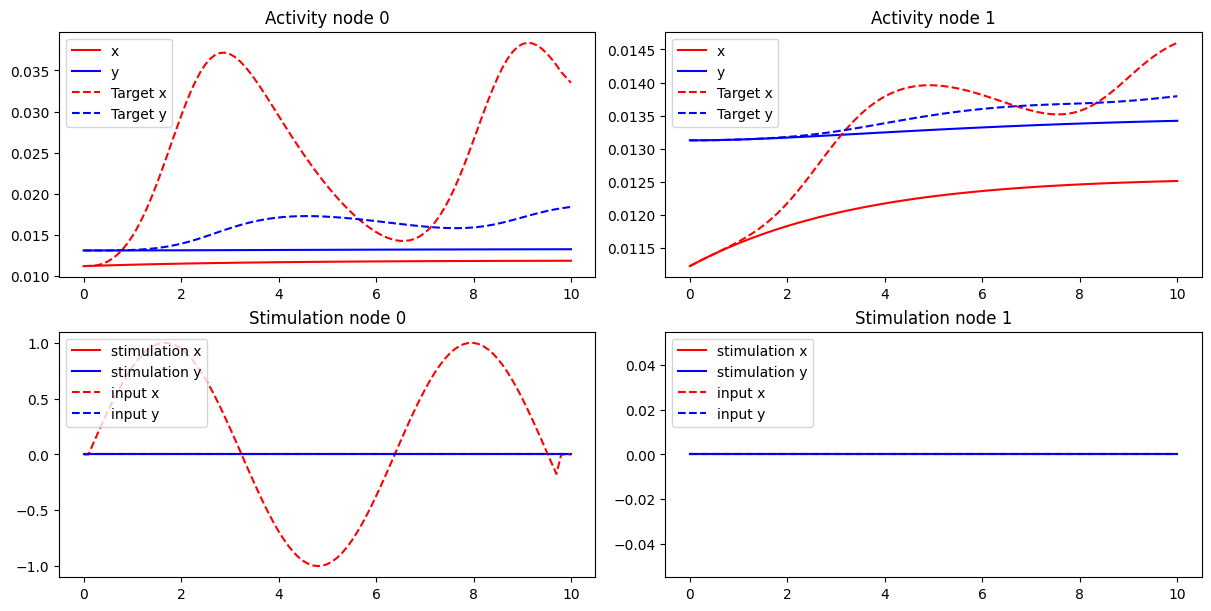

In [16]:
cmat = np.array( [[0., 0.5], [1., 0.]] )  # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0., 0.]] )  # no delay

model = WCModel(Cmat=cmat, Dmat=dmat)

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in x-channel in node 0

model.params.K_gl = 5.

model.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = np.copy(zero_input)
input[0,1:-3] = np.sin(np.arange(0,duration-0.3, dt)) # other functions or random values can be used as well
model.params["exc_init"] = np.vstack( [x_init, x_init] )
model.params["inh_init"] = np.vstack( [y_init, y_init] )


# We set the stimulus in x and y variables, and run the simulation
input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state =  np.concatenate( (np.concatenate( (model.params["exc_init"], model.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 8.117061134315108e-06
Cost in iteration 25: 3.3449246136096844e-07
Cost in iteration 50: 1.1120852070616967e-07
Cost in iteration 75: 5.479216242208133e-08
Cost in iteration 100: 3.182537085204132e-08
Cost in iteration 125: 2.0189339789955558e-08
Cost in iteration 150: 1.368062801512599e-08
Cost in iteration 175: 9.813707533872807e-09
Cost in iteration 200: 7.414093529026537e-09
Cost in iteration 225: 5.8062436566099894e-09
Cost in iteration 250: 4.764549196437278e-09
Cost in iteration 275: 4.011164734513859e-09
Cost in iteration 300: 3.4856196187350843e-09
Cost in iteration 325: 3.0840089026363144e-09
Cost in iteration 350: 2.7646074784470672e-09
Cost in iteration 375: 2.523996093984088e-09
Cost in iteration 400: 2.3276391797402083e-09
Cost in iteration 425: 2.161117274987237e-09
Cost in iteration 450: 2.017963772311649e-09
Cost in iteration 475: 1.8984278399118907e-09
Cost in itera

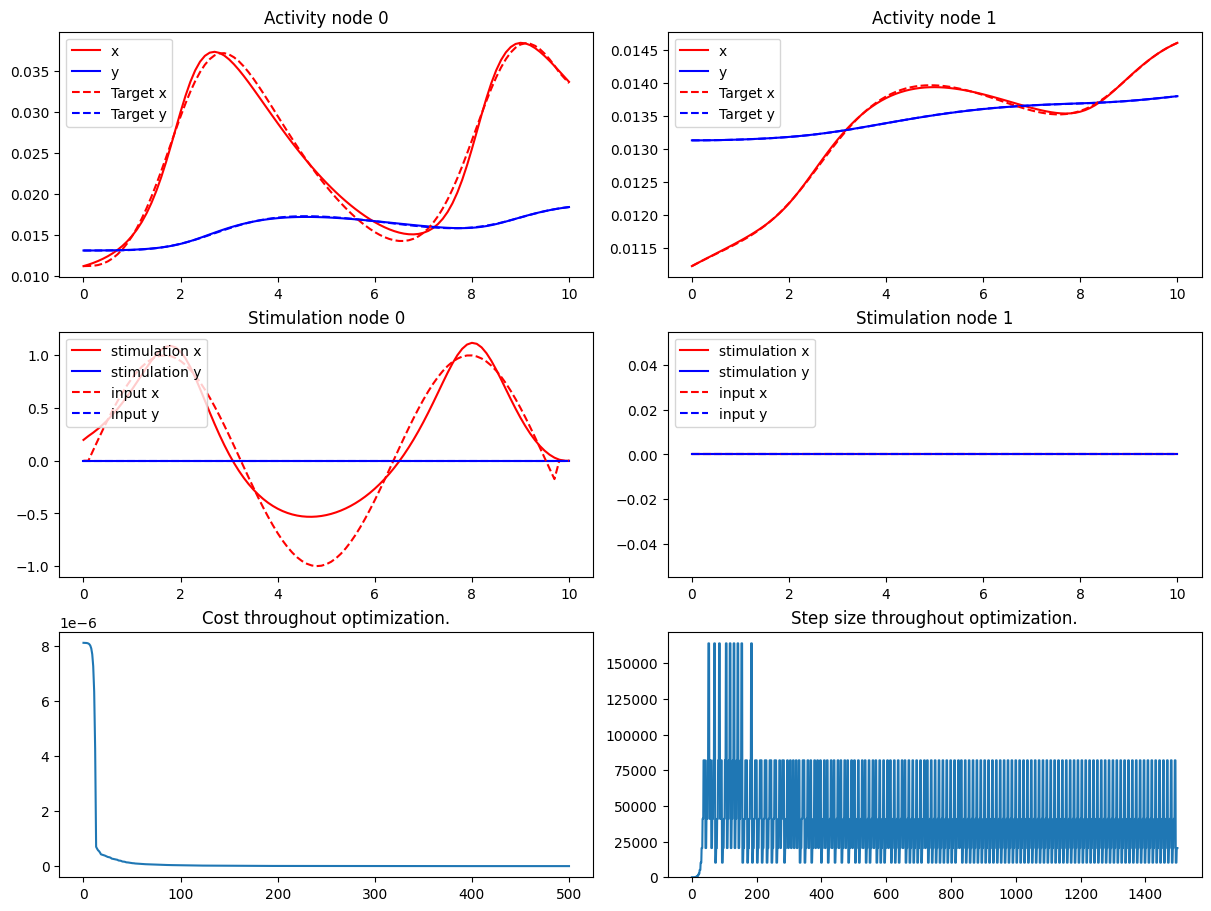

In [17]:
# we define the precision matrix to specify, in which nodes and channels we measure deviations from the target
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[1,0] = 1. # only measure in y-channel in node 1

# We set the external stimulation to zero. This is the "initial guess" for the OC algorithm
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]

# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 1.7950376760712586e-09
Cost in iteration 25: 1.7078999109778277e-09
Cost in iteration 50: 1.6279262235210567e-09
Cost in iteration 75: 1.5558405468301443e-09
Cost in iteration 100: 1.4937785279178973e-09
Final cost : 1.4937785279178973e-09


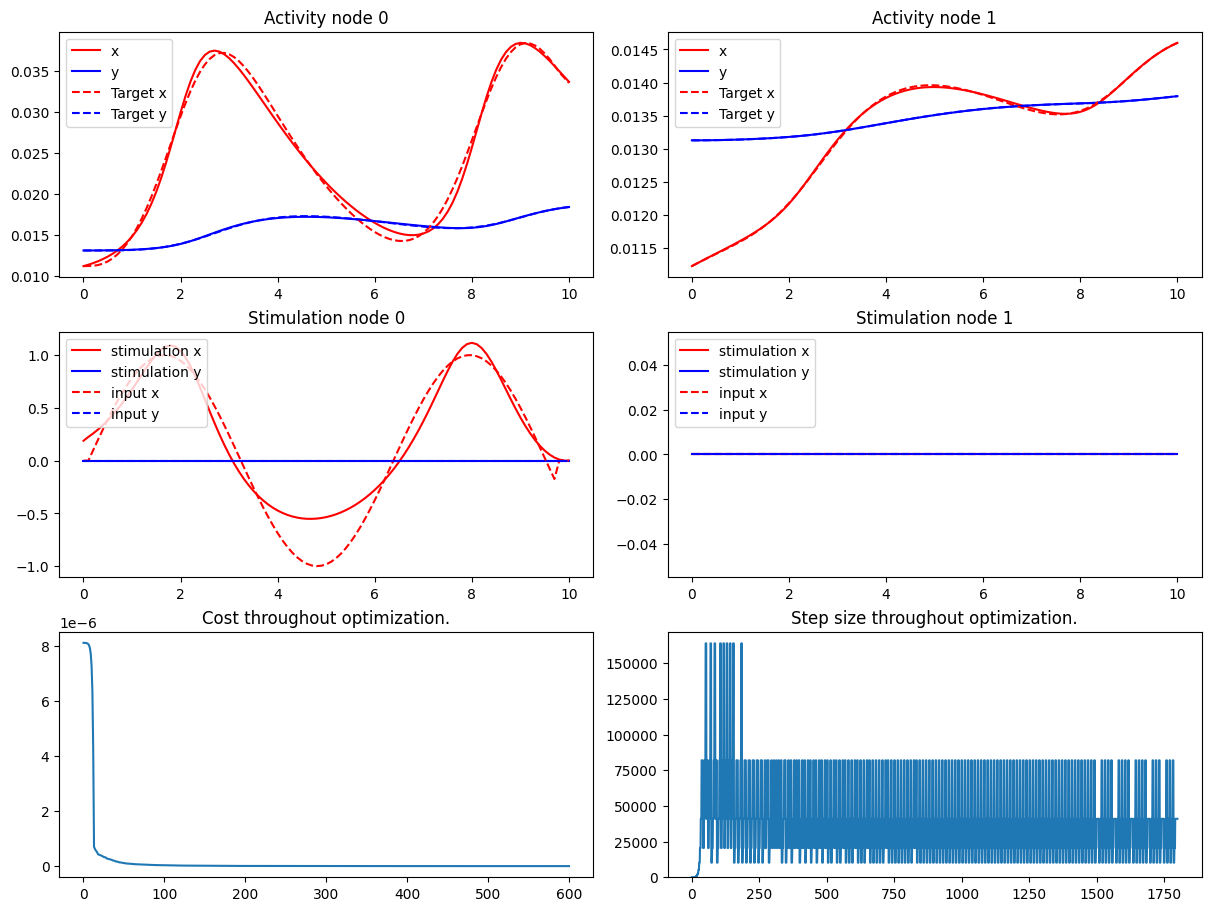

In [18]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

### Delayed network of neural populations

We now consider a network topology with delayed signalling between the two nodes.

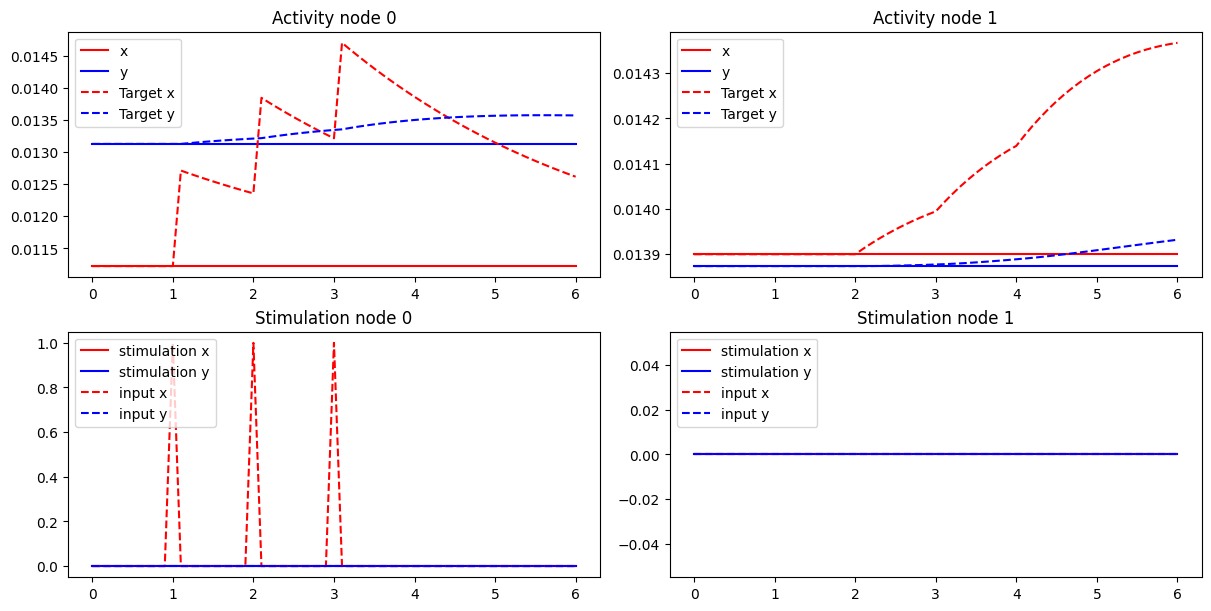

In [19]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0.], [18, 0.]] ) # distance from 0 to 1, delay is computed by dividing by the signal speed params.signalV

model = WCModel(Cmat=cmat, Dmat=dmat)

duration, dt = 2000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 10.

model.run()

e0 = model.exc[0,-1]
e1 = model.exc[1,-1]
i0 = model.inh[0,-1]
i1 = model.inh[1,-1]

maxdelay = model.getMaxDelay()

model.params["exc_init"] = np.array([[e0] * (maxdelay + 1), [e1] * (maxdelay + 1) ])
model.params["inh_init"] = np.array([[i0] * (maxdelay + 1), [i1] * (maxdelay + 1) ])

duration = 6.
model.params.duration = duration
model.run()

# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,10] = 1. 
input[0,20] = 1.
input[0,30] = 1. # Three pulses as control input

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]
model.run()

# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)
plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 1.7928350533911487e-07
Cost in iteration 25: 2.4024139973245853e-10
Cost in iteration 50: 7.916382096246932e-11
Cost in iteration 75: 6.53982757628069e-11
Cost in iteration 100: 5.794852729072051e-11
Cost in iteration 125: 5.250489118668182e-11
Cost in iteration 150: 4.838024700807522e-11
Cost in iteration 175: 4.522905904346144e-11
Cost in iteration 200: 4.2834246231610614e-11
Cost in iteration 225: 4.0756481096231357e-11
Cost in iteration 250: 3.921639188359775e-11
Cost in iteration 275: 3.77465933735942e-11
Cost in iteration 300: 3.660809380107628e-11
Cost in iteration 325: 3.560424767126712e-11
Cost in iteration 350: 3.47216565959393e-11
Cost in iteration 375: 3.397191014542112e-11
Cost in iteration 400: 3.331688665967866e-11
Cost in iteration 425: 3.2713506962768754e-11
Cost in iteration 450: 3.2061758676121197e-11
Cost in iteration 475: 3.147358940031412e-11
Cost in iteration 5

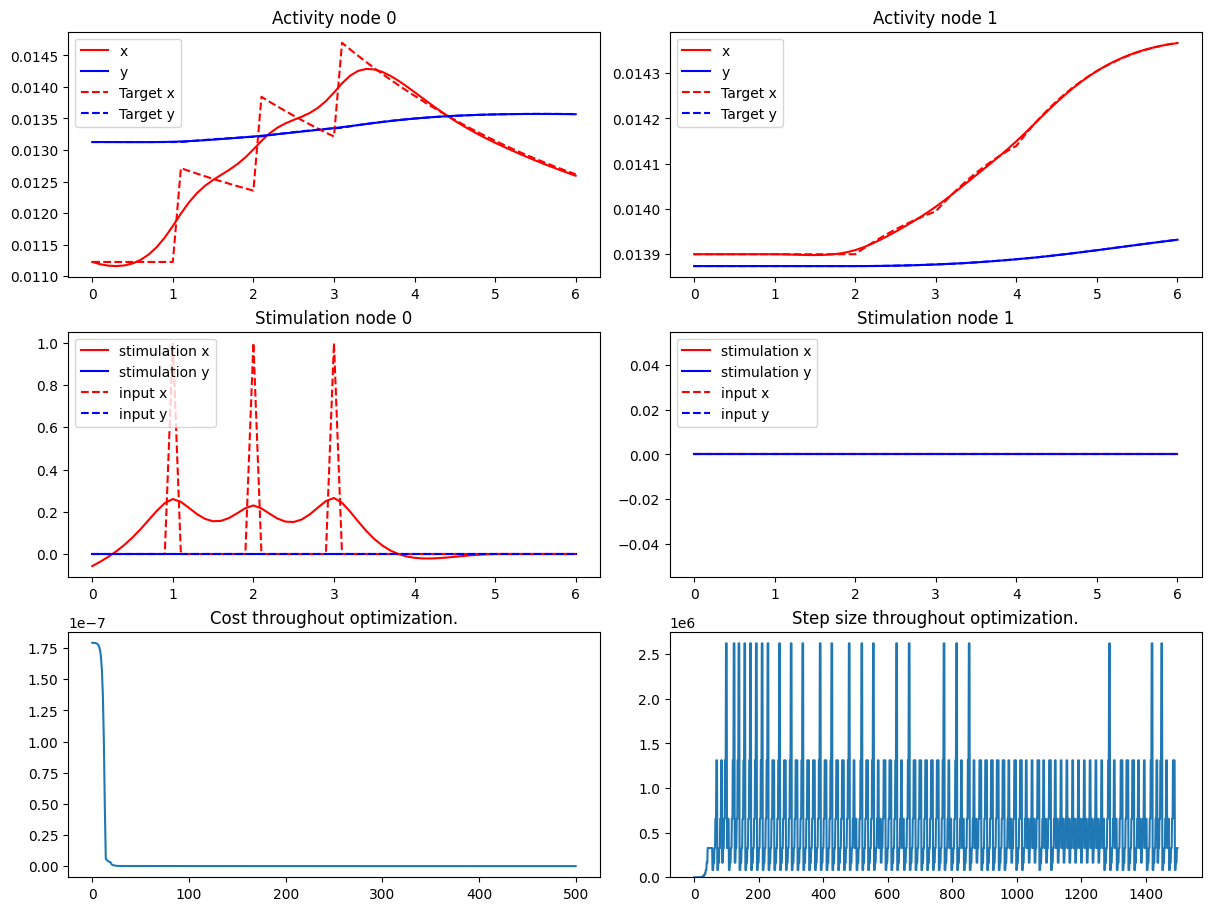

In [20]:
# We load the optimal control class
# print array (optional parameter) defines, for which iterations intermediate results will be printed
# Parameters will be taken from the input model
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(500)

state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 3.090639086256622e-11
Cost in iteration 25: 3.036774092710983e-11
Cost in iteration 50: 2.978451987206539e-11
Cost in iteration 75: 2.932094145623295e-11
Cost in iteration 100: 2.8874289902135814e-11
Final cost : 2.8874289902135814e-11


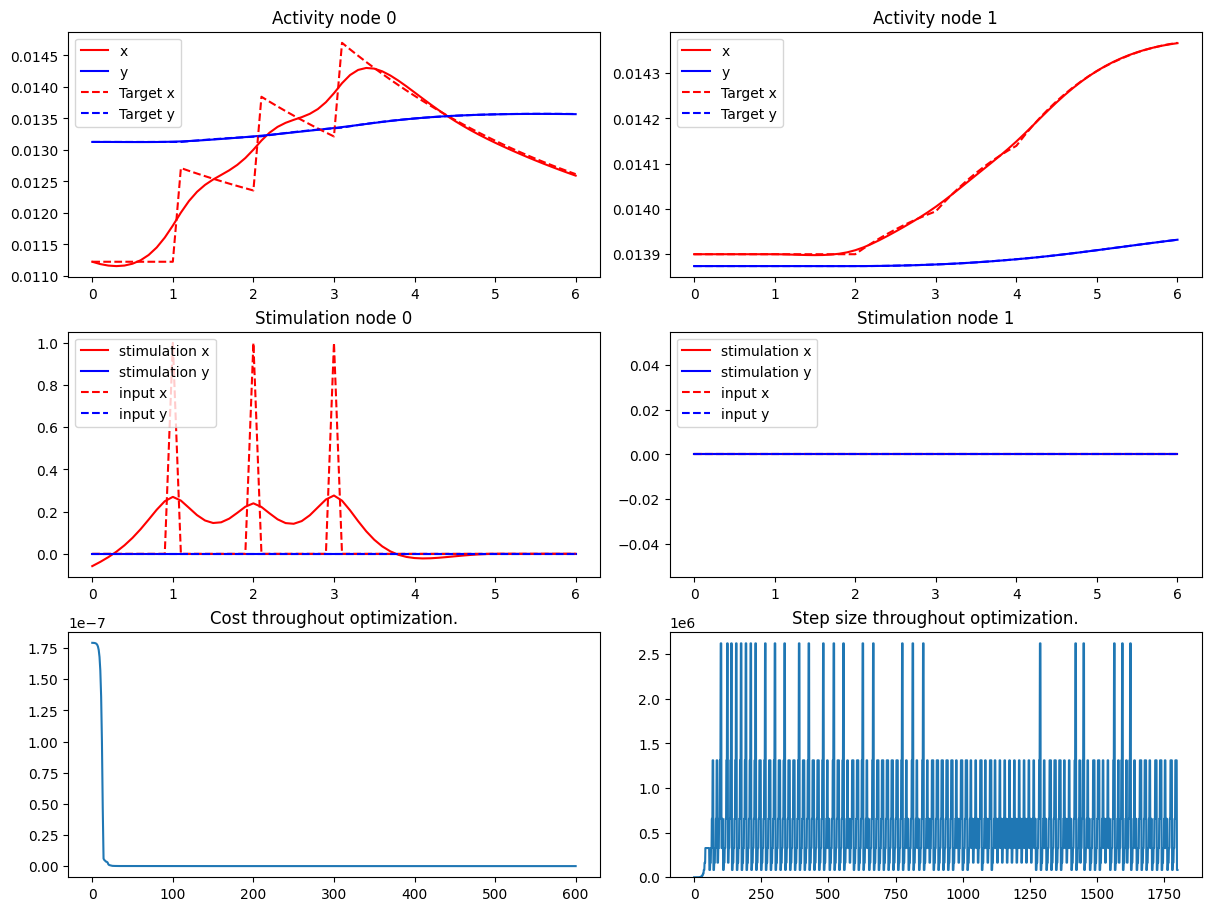

In [21]:
# perofrm another 100 iterations to improve result
# repeat execution to add another 500 iterations
# converence to the input stimulus is relatively slow for the WC nodel
model_controlled.optimize(100)
state = model_controlled.get_xs()
control = model_controlled.control
plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)